## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated','lastSeen'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  datetime64[ns]
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   vehicleType          237765 non-null  object        
 6   yearOfRegistration   371528 non-null  int64         
 7   gearbox              351319 non-null  object        
 8   powerCV              371528 non-null  float64       
 9   model                351044 non-null  object        
 10  kilometer            371528 non-null  int64         
 11  monthOfRegistration  371528 non-null  int64         
 12  fuelType             338142 non-null  object        
 13  brand         

## Selección de columnas

Vamos a eliminar columnas que no nos aporten información relevante:
- **dateCrawled**, **dateCreated**, **lastSeen**: en el EDA preliminar habíamos visto que los anuncios son de 2014 y 2016 y que más allá de eso no nos aporta más información.
- **seller**: Todos los valores son private salvo 3 entradas, que son commercial. Vamos a eliminar directamente la columna.
- **offerType**: De igual forma, todos los valores son offer salvo 12 entradas, que son request. Podemos eliminar la columna y los vehículos que son request.
- **model**: Tenemos más de 250 categorías diferentes y es una subcategoría de brand. Podemos dejarla para un análisis más granular pero ahora vamos a eliminarla.
- **monthOfRegistration**: Podríamos hacer un análisis de estacionalidad o temporadas, pero no será el caso. Además, hay un valor que es 0, lo cual es imposible para meses por lo que realmente sería desconocido. Utilizaremos solamente **yearOfRegistration**.
- **nrOfPictures**: Todos los valores son 0 por lo que no aporta valor.
- **postalCode**: Esta variable corresponde a códigos postales y podría tratarse como categórica. Sin embargo, no nos aporta mucha información que nos resulte útil por lo que decidimos eliminarla.

### Eliminar duplicados

In [4]:
df = df.drop_duplicates()

In [5]:
columnas_eliminar = [
    'dateCrawled',
    'dateCreated',
    'lastSeen',
    'seller',
    'offerType',
    'model',
    'monthOfRegistration',
    'nrOfPictures',
    'postalCode'
]

In [6]:
df = df.drop(columns=columnas_eliminar)

In [7]:
df.duplicated().sum()

np.int64(11622)

Fijémonos en que ahora puede haber duplicados ya que pueden ser diferentes unidades del mismo vehículo. En este caso, no tenemos forma de saber si es el mismo o diferente ya que no tenemos un identificadoor único (name puede ser el mismo), asi que los vamos a dejar por si acaso.

## Limpieza de datos

Vamos a hacer una limpieza columna a columna

In [8]:
df.columns

Index(['name', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerCV', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

Nos vamos a saltar la de name porque en este análisis no es relevante y no la vamos a utilizar

### Columna `price`

Valores extremadamente bajos de precio no tienen sentido. Sin embargo, es ddificil establecer un criterio escrito para filtrar ya que los vehiculos muy antiguos o con daños realmente pueden tener precios muy bajos. 

In [9]:
print(f"El porcentaje de valores nulos en la columna price es: {df['price'].isna().sum()}")

El porcentaje de valores nulos en la columna price es: 0


Como no teníamos valores nuloos, veamos qué proporción de vehículos tienen un valor inferior a cierto umbral. Podemos elegir el umbral por ejemplo en 100 (presumiblemente euros).

In [10]:
umbral_precio_inferior = 100

porcentaje_baratos = (df['price'] < umbral_precio_inferior).mean()*100

print(f"El porcentaje de vehículo por debajo de {umbral_precio_inferior} es: {round(porcentaje_baratos, 2)}%")

El porcentaje de vehículo por debajo de 100 es: 3.59%


Los datos con un precio inferior a 100 son muy probablemente erróneos y representan alrededor ddel 3,6% del conjunto de datos, por lo que parece razonable eliminarlos.

Es posible que haya vehículos que realmente tengan un precio por debajo de 100 debido a daños no reparados o a su antigüedad, pero es dddificil establecer este criterio, asi que procederemos de esta manera.

Veamos ahora qué sucedde con los vehículos con un precio muy elevado. Pongamos el umbral de 4M.

In [11]:
umbral_precio_superior = 4e6

porcentaje_caros = (df['price'] > umbral_precio_superior).mean()*100

print(f"El porcentaje de vehículo por encima de {umbral_precio_superior} es: {porcentaje_caros:.3f}%")

El porcentaje de vehículo por encima de 4000000.0 es: 0.014%


Podemos revisar manualmente estos datos para comprobar si tiene sentido:

In [12]:
df[df['price'] > umbral_precio_superior].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
251980,Audi_A6_2.7_TDI_quattro_S_Line_Luftfederung_Bose,99000000,NaN,2009,automatic,187.0,150000,diesel,audi,no
77520,Tausch_gegen_gleichwertiges,99999999,NaN,1999,automatic,221.0,150000,petrol,mercedes_benz,NaN
347435,Schlachte_Golf_4_1.4_16_fast_alles_noch_da,9999999,NaN,2000,manually,74.0,150000,petrol,volkswagen,yes
196306,Suche_Motorcross_.!,10000000,NaN,2017,manually,0.0,5000,petrol,volkswagen,NaN
150909,Suche_Autos_Model_egal_welches,99999999,NaN,1990,NaN,0.0,5000,NaN,sonstige_autos,NaN


Tras revisar los datos, podemos concluir que todos los precios superiores a 4 millones corresponden a registros erróneos.

Por lo tanto, filtramos los datos por precios de esta forma:

In [13]:
filtro_precio = (df['price'] > umbral_precio_inferior) & (df['price'] < umbral_precio_superior)
df = df[filtro_precio]

## Columna `yearOfRegistration `

Tal y comoo vimos con las columnas de fechas de los anuncios, los registros no puedenn ser de después de 2016. Sin embargo, vamos a comprobar las entradas posteriores a este año.

In [14]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts()

yearOfRegistration
2017    9925
2018    3797
2019      15
9999      14
5000      14
6000       6
9000       4
3000       4
7000       4
4000       3
5555       2
5911       2
2500       2
4500       2
8888       2
3200       1
5300       1
2066       1
2200       1
4100       1
3700       1
8500       1
2900       1
5900       1
2290       1
6200       1
4800       1
3800       1
7500       1
9450       1
5600       1
7777       1
2800       1
7800       1
7100       1
8200       1
Name: count, dtype: int64

Vemos que hay unas cuantas entradas en 2017 y 2018, por lo que vamos a mantenerlas ya que es posible que las columnas de fechas que habíamos eliminado posiblemente fuesen las que estaban mal. 

El resto de años son mucho menos frecuentes y la mayoría no tienen sentido por lo que poddemos asumir que son errores y eliminarlos o etiquetarlos como nulos.

In [15]:
# Nos quedamos con las entradas que sean anteriores a 2019 (el umbral de años que hemos establecido)
df = df[df['yearOfRegistration'] < 2019]

Veamos que ocurre ahora con vehículos con fechas de registro muy antiguas. Por ejemplo, establecemos el umbral en 1950

In [16]:
umbral_fecha = 1950

df[df['yearOfRegistration'] < umbral_fecha]['yearOfRegistration'].value_counts()

yearOfRegistration
1910    36
1000    23
1937    12
1938     8
1929     7
1936     7
1943     5
1945     5
1935     5
1933     5
1947     5
1930     4
1800     4
1941     4
1931     4
1932     4
1934     4
1939     4
1948     3
1234     3
1923     3
1949     3
1928     2
1300     2
1927     2
1940     2
1500     2
1942     2
1944     2
1111     2
1600     2
1946     2
1925     1
1400     1
1911     1
1001     1
1039     1
1602     1
Name: count, dtype: int64

Vemos que tenemos 36 entradas de 1910, que seguramente sean errores (por la fecha de invención del coche). Veamos la distribución de forma gráfica más detallada.

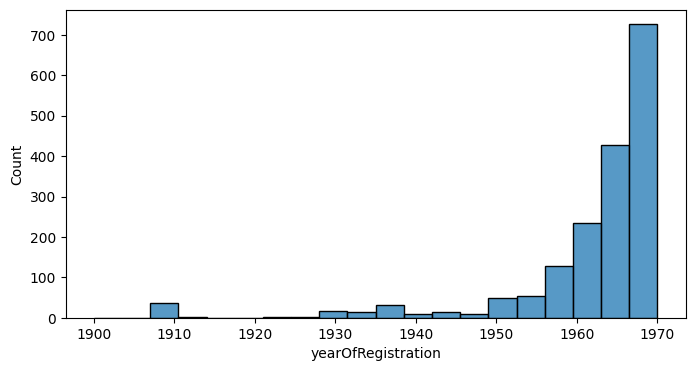

In [17]:
plt.figure(figsize=(8,4))
sns.histplot(df['yearOfRegistration'], bins=20, binrange=(1900,1970))
plt.show()

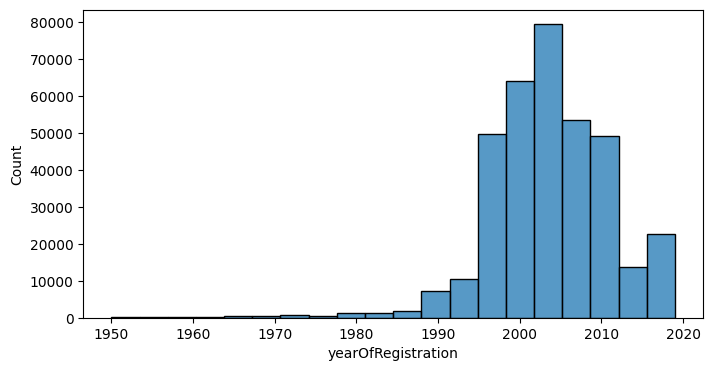

In [18]:
plt.figure(figsize=(8,4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(umbral_fecha,2019))
plt.show()

Podemos examinar individualmente las entradas de vehículoos más antiguos para ver si genuinamente son errores.

In [19]:
df[df['yearOfRegistration'] < umbral_fecha].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
59830,Suche_Fahrzeug_mit_Anhaengerkupplung_und_LPG_G...,1000,NaN,1910,NaN,0.0,150000,NaN,sonstige_autos,NaN
279481,Oldtimer_Sport___Cabrio_Georges_Irat,8500,convertible,1938,manually,0.0,5000,petrol,sonstige_autos,yes
55825,Andere_Horch_830,235000,convertible,1933,manually,68.0,150000,NaN,sonstige_autos,no
234842,Autos_zum_Ausschlachten_oder_als_Bastlerfahrzeuge,1500,bus,1910,manually,985.0,150000,NaN,renault,NaN
151072,Jeep_Willys_H_Kennzeichen__EZ.1943_TÜV_neu__ke...,15999,suv,1943,manually,53.0,50000,diesel,jeep,no


Vemos que la mayoría de estas entradas parecen ser erróneas por lo que directamente vamos a aplicar un filtro para eliminarlas.

También podríamos convertir su año a nulo y luego gestionarlos, pero al tener tan poca información y ser pocas entradas del dataset no nos compensa.

In [20]:
# Nos quedamos con las entradas que sean posteriores a 1950 (el umbral de años que hemos establecido)
df = df[df['yearOfRegistration'] > umbral_fecha]

### Columna `powerCV`

Un vehículo con una potencia de más de 1200CV prácticamente no existe, y menos aún que se venda de segunda mano. Estos valores serán convertidos a nulos.

Por otra parte, es muy poco frecuente tener vehículos en el rango entre 550CV y 1200CV, incluso siendo deportivos. Vamos a ver la distribución de este rango.


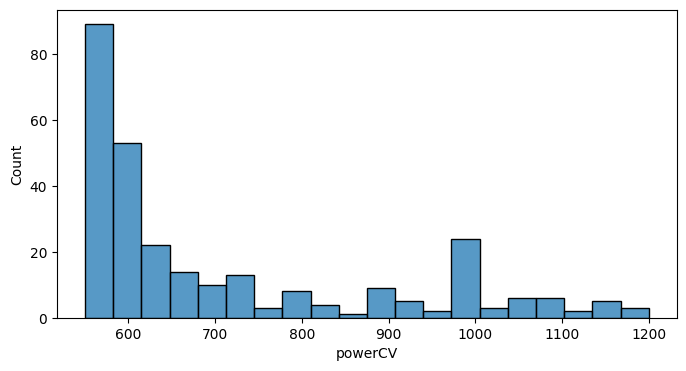

In [21]:
umbral_superior_cv = 550
plt.figure(figsize=(8,4))

sns.histplot(df['powerCV'], bins=20, binrange=(umbral_superior_cv, 1200))
plt.show()

In [22]:
df = df[df['powerCV'] < umbral_superior_cv]

En cuanto al rango inferior de potencia, los vehículos con potencia inferior a cierto valor no son realistas. Pongamos un umbral de 40CV.

In [23]:
df[df['powerCV'] < 40].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
281259,Golf_V_Lim._Sportline,2600,small car,2004,NaN,0.0,150000,diesel,volkswagen,NaN
341007,Ford_Focus_1.6V_Bj._2001,1150,small car,2001,manually,0.0,150000,petrol,ford,no
331473,7_Sitzer_zu_verkaufen,1000,bus,2000,manually,0.0,150000,petrol,ford,no
189580,Mazda_Mazda2_Tuev_09/16,1999,small car,2003,NaN,0.0,150000,petrol,mazda,no
131218,Renault_Scenic,1980,NaN,2017,manually,0.0,150000,NaN,renault,no


In [24]:
df[df['powerCV'] < 40].shape[0]

36668

Vemos que hay muchas con un valor 0 o valores que no tienen sentido. Como son bastantes entradas, no las vamos a eliminar, sino reemplazarlas por nulos.

In [25]:
# Generar nulos para estos valores
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if x < 40 else x)

### Columna `kilometer`

Los km acumulados por un vehículo es una variable numérica continua. Sin embargo, los datos parecen estar agrupados en intervalos discretos.

In [26]:
df['kilometer'].value_counts()

kilometer
150000    230462
125000     37122
100000     15305
90000      12285
80000      10842
70000       9619
60000       8553
50000       7496
40000       6293
30000       5885
20000       5445
5000        5236
10000       1762
Name: count, dtype: int64

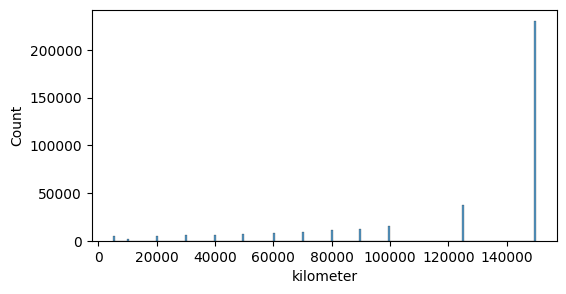

In [27]:
plt.figure(figsize=(6,3))
sns.histplot(df['kilometer'])
plt.show()

No parece haber ningun valor que sea extraño por lo que vamos a dejarlo como está

### Columna vehicleType

In [28]:
df['vehicleType'].value_counts(dropna=False)

vehicleType
NaN            125614
small car       77121
combi           65679
bus             29653
convertible     22436
coupe           18292
suv             14438
other            3072
Name: count, dtype: int64

Vemos que tenemos 7 tipos de valores con una gran cantidad de nulos. Poddemos directamente crear una nueva categoria que sea unknown

In [29]:
df['vehicleType'] = df['vehicleType'].fillna('unknown')

In [30]:
df['vehicleType'].value_counts()

vehicleType
unknown        125614
small car       77121
combi           65679
bus             29653
convertible     22436
coupe           18292
suv             14438
other            3072
Name: count, dtype: int64

### Columna `gearbox`

In [31]:
df['gearbox'].value_counts(dropna=False)

gearbox
manually     264811
automatic     75215
NaN           16279
Name: count, dtype: int64

In [32]:
df['gearbox'] = df['gearbox'].fillna('unknown')

### Columna `fuelType`

In [33]:
df['fuelType'].value_counts(dropna=False)

fuelType
petrol     215919
diesel     105839
NaN         28258
lpg          5217
cng           551
hybrid        271
other         153
electro        97
Name: count, dtype: int64

In [34]:
df['fuelType'] = df['fuelType'].fillna('unknown')

### Columna `brand`

In [35]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'porsche', 'sonstige_autos', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover',
       'saab', 'land_rover', 'trabant', 'lada'], dtype=object)

Fijémonos que sonstige_autos se traduce como otros_vehiculos por lo que podemos modificar a other

In [38]:
df['brand'] = df['brand'].replace({'sonstige_autos': 'other'})

In [39]:
df['brand'].value_counts().head()

brand
volkswagen       76182
bmw              38820
opel             38097
mercedes_benz    34358
audi             31744
Name: count, dtype: int64

### Columna `notRepairedDamage`

In [40]:
df['notRepairedDamage'].value_counts(dropna=False)

notRepairedDamage
no     258639
NaN     64431
yes     33235
Name: count, dtype: int64

In [41]:
df['notRepairedDamage'] = df['notRepairedDamage'].fillna('unknown')

## Guardamos los datos limpios

In [42]:
df.to_csv('../data/output/autorenew_limpio.csv', index=False)